# BLIP: Inference Demo
 - [Image Captioning](#Image-Captioning)
 - [VQA](#VQA)
 - [Feature Extraction](#Feature-Extraction)
 - [Image Text Matching](#Image-Text-Matching)

In [1]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP

In [1]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
from PIL import ImageDraw

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_image(image_size,device,img_url):
    
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image
def load_local_image(image_size, device, image_path):
    raw_image = Image.open(image_path).convert('RGB')
    
    # (opcional) Mostrar imagen
    w, h = raw_image.size
    display(raw_image.resize((w // 5, h // 5)))

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                             (0.26862954, 0.26130258, 0.27577711))
    ])
    
    image = transform(raw_image).unsqueeze(0).to(device)
    return image

# Image Captioning
Perform image captioning using finetuned BLIP model

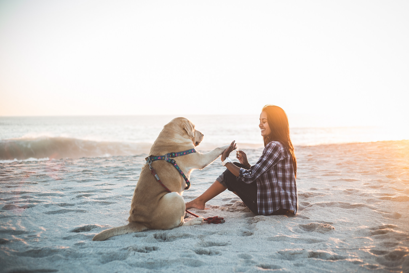

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model*_base_caption.pth
caption: a woman sitting on the beach with a dog


In [4]:
from models.blip import blip_decoder

image_size = 384
image = load_demo_image(image_size=image_size, device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
    
model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

with torch.no_grad():
    # beam search
    caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
    # nucleus sampling
    # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
    print('caption: '+caption[0])

# Feature Extraction

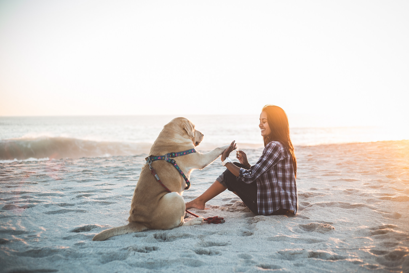

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth


In [13]:
from models.blip import blip_feature_extractor

image_size = 224
image = load_demo_image(image_size=image_size, device=device)     

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth'
    
model = blip_feature_extractor(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

caption = 'a woman sitting on the beach with a dog'

multimodal_feature = model(image, caption, mode='multimodal')[0,0]
image_feature = model(image, caption, mode='image')[0,0]
text_feature = model(image, caption, mode='text')[0,0]

# VQA
Perform visual question answering using finetuned BLIP model

In [4]:
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
import requests
from io import BytesIO
import torch

# Configuración
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
question = "Return the final disccount"
image_path = "/home/anovalbos/halldetect/segclip/blip1/docs/Template1_Instance0.jpg"
# Cargar modelo y processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base", trust_remote_code=True)
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base", trust_remote_code=True)
model.to(device)
model.eval()

image = Image.open(image_path).convert("RGB")

# Procesar y generar respuesta
inputs = processor(images=image, text=question, return_tensors="pt").to(device)
with torch.no_grad():
    output = model.generate(**inputs)
    answer = processor.tokenizer.decode(output[0], skip_special_tokens=True)

print("Answer:", answer)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Answer: 7


# Image-Text Matching

In [2]:
from models.blip_itm import blip_itm
import os

img_url = 'https://dialaborable.com/wp-content/uploads/2022/12/ejemplo-de-contrato-de-trabajo-en-practicas-rellenado-724x1024.png' 
image_size = 384
#image = load_demo_image(image_size=image_size,device=device,img_url=img_url)
image_path = os.path.join("/home/anovalbos/halldetect/segclip/blip1/docs/Template1_Instance0.jpg")
image = load_local_image(image_size=image_size, device=device, image_path=image_path)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'
    
model = blip_itm(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device='cuda')


answerITM = 'a discount applied to the total value'

print('text: %s' %answerITM)

itm_output = model(image,answerITM,match_head='itm')
itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
print('The image and text is matched with a probability of %.4f'%itm_score)

itc_score = model(image,answerITM,match_head='itc')
print('The image feature and text feature has a cosine similarity of %.4f'%itc_score)


/home/anovalbos/miniforge3/envs/blip1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/anovalbos/miniforge3/envs/blip1/lib/python3.11/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-06-23 06:47:19.061550: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-23 06:47:19.169844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already bee

KeyboardInterrupt: 

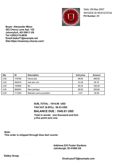

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
Imagen: 595x841
Celdas horizontales: 3, celdas verticales: 4
Solape horizontal: 77.50, solape vertical: 53.00


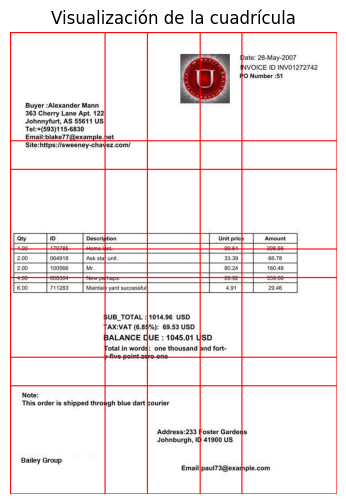

Tile 1 ((0, 0, 250, 250)):
  ITM Match Probability: 0.3533
  ITC Cosine Similarity: 0.3120


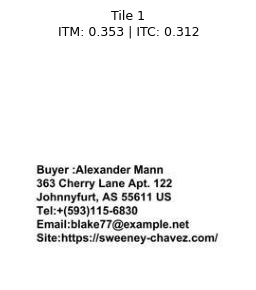

Tile 2 ((172, 0, 422, 250)):
  ITM Match Probability: 0.1970
  ITC Cosine Similarity: 0.2318


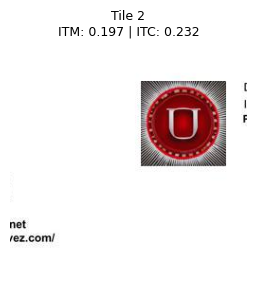

Tile 3 ((345, 0, 595, 250)):
  ITM Match Probability: 0.3879
  ITC Cosine Similarity: 0.2577


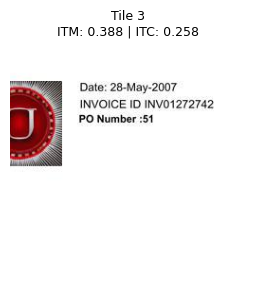

Tile 4 ((0, 197, 250, 447)):
  ITM Match Probability: 0.2118
  ITC Cosine Similarity: 0.2419


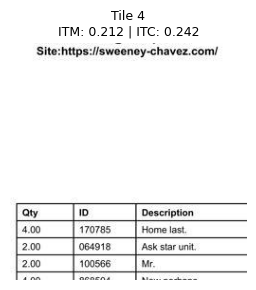

Tile 5 ((172, 197, 422, 447)):
  ITM Match Probability: 0.0576
  ITC Cosine Similarity: 0.1914


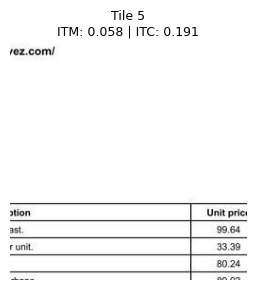

Tile 6 ((345, 197, 595, 447)):
  ITM Match Probability: 0.0312
  ITC Cosine Similarity: 0.1641


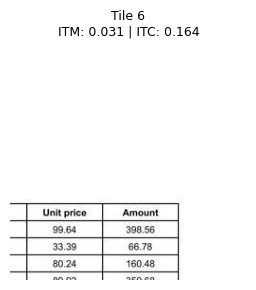

Tile 7 ((0, 394, 250, 644)):
  ITM Match Probability: 0.0661
  ITC Cosine Similarity: 0.1761


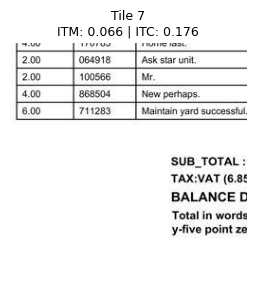

Tile 8 ((172, 394, 422, 644)):
  ITM Match Probability: 0.0293
  ITC Cosine Similarity: 0.1773


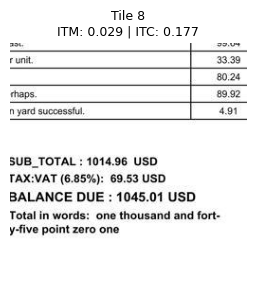

Tile 9 ((345, 394, 595, 644)):
  ITM Match Probability: 0.0156
  ITC Cosine Similarity: 0.1581


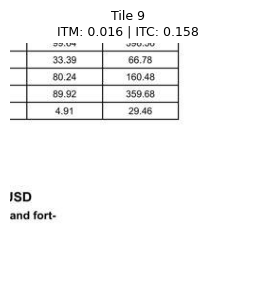

Tile 10 ((0, 591, 250, 841)):
  ITM Match Probability: 0.0681
  ITC Cosine Similarity: 0.1880


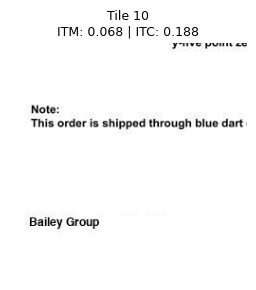

Tile 11 ((172, 591, 422, 841)):
  ITM Match Probability: 0.4806
  ITC Cosine Similarity: 0.2638


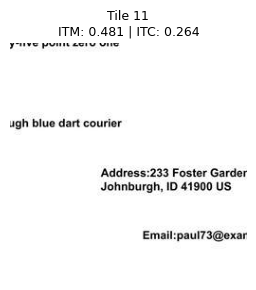

Tile 12 ((345, 591, 595, 841)):
  ITM Match Probability: 0.2995
  ITC Cosine Similarity: 0.2683


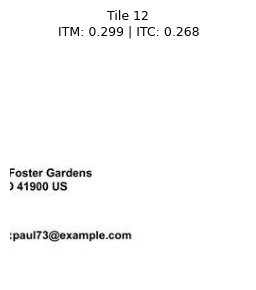

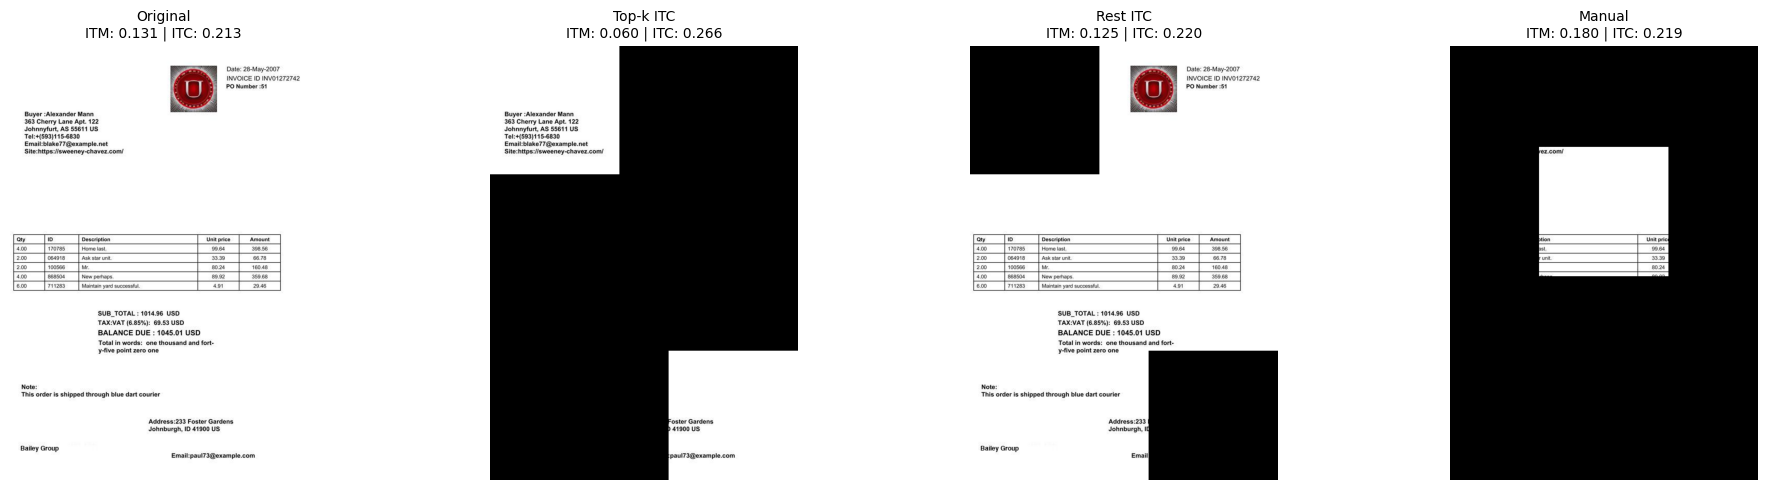

In [3]:
import os
import math
import torch
from PIL import Image
from typing import List, Tuple
from models.blip_itm import blip_itm
from torchvision import transforms
from typing import List, Tuple
import numpy as np



# Función para cargar la imagen local y redimensionarla ya hay una pero esta es para la prueba entera
def load_local_image(image_size, device, image_path):
    raw_image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                             (0.26862954, 0.26130258, 0.27577711))])
    image = transform(raw_image).unsqueeze(0).to(device)
    w, h = raw_image.size
    display(raw_image.resize((w // 5, h // 5)))
    return raw_image, image  # retornamos también la imagen PIL

# calculo el solape entre regiones
def calcular_solape_exacto(dimension_total, tam_tile):
    n_tiles = math.ceil((dimension_total - tam_tile) / (tam_tile - 1e-6)) + 1
    stride = (dimension_total - tam_tile) / (n_tiles - 1) if n_tiles > 1 else 0
    solape = tam_tile - stride
    return solape, n_tiles
#hago las regiones de 250 pixeles sobre la imagen
def make_grid_boxes(img: Image.Image, tam_tile=250) -> List[Tuple[int,int,int,int]]:
    w, h = img.size
    solape_w, n_cols = calcular_solape_exacto(w, tam_tile)
    solape_h, n_rows = calcular_solape_exacto(h, tam_tile)
    boxes = []

    for i in range(n_rows):
        for j in range(n_cols):
            x0 = int(j * (tam_tile - solape_w))
            y0 = int(i * (tam_tile - solape_h))
            x1 = x0 + tam_tile
            y1 = y0 + tam_tile

            if x1 > w:
                x1 = w
                x0 = w - tam_tile
            if y1 > h:
                y1 = h
                y0 = h - tam_tile

            boxes.append((x0, y0, x1, y1))

    print(f"Imagen: {w}x{h}")
    print(f"Celdas horizontales: {n_cols}, celdas verticales: {n_rows}")
    print(f"Solape horizontal: {solape_w:.2f}, solape vertical: {solape_h:.2f}")
    return boxes
# Visualización de la grilla sobre la imagen
def visualize_grid(img: Image.Image, boxes: List[Tuple[int,int,int,int]]):
    overlay = img.copy()
    draw = ImageDraw.Draw(overlay)
    for box in boxes:
        draw.rectangle(box, outline="red", width=2)
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Visualización de la cuadrícula")
    plt.show()
#visualizo las celdas con los scores individuales
def show_tile_with_scores(tile: Image.Image, idx: int, box: Tuple[int, int, int, int], itm: float, itc: float):
    plt.figure(figsize=(3, 3))
    plt.imshow(tile)
    plt.axis("off")
    plt.title(f"Tile {idx}\nITM: {itm:.3f} | ITC: {itc:.3f}", fontsize=9)
    plt.tight_layout()
    plt.show()

def split_topk_itc_boxes(boxes: List[Tuple[int,int,int,int]], itc_scores: List[float], k: int):
    assert len(boxes) == len(itc_scores), "Boxes and scores must have the same length"

    # Emparejar cada box con su ITC score
    box_score_pairs = list(zip(boxes, itc_scores))

    # Ordenar por score ITC de mayor a menor
    sorted_pairs = sorted(box_score_pairs, key=lambda x: x[1], reverse=True)

    # Dividir en top-k y el resto
    topk_boxes = [box for box, score in sorted_pairs[:k]]
    rest_boxes = [box for box, score in sorted_pairs[k:]]

    return topk_boxes, rest_boxes
def mask_img_from_pixel(img: Image.Image, boxes: List[Tuple[int,int,int,int]], relevant: List[bool]) -> Image.Image:
    mask = np.zeros((img.height, img.width), dtype=bool) #creo una matriz de ceros del tamaño de la imagen
    for box, is_rel in zip(boxes, relevant):#recorro tanto los boxes como la lista relevant y si una celda es relevante pongo todos sus pixeles a 1
        if is_rel:
            x0, y0, x1, y1 = box
            mask[y0:y1, x0:x1] = True  # Marcar región como relevante

    img_np = np.array(img) #se convierte la imagen a un array de numpy
    img_np[~mask] = 0  # Poner en negro los píxeles irrelevantes
    return Image.fromarray(img_np)
def mask_image_from_pixel_mask_irre(img: Image.Image, boxes: List[Tuple[int,int,int,int]], relevant: List[bool]) -> Image.Image:
    mask = np.zeros((img.height, img.width), dtype=bool) #creo una matriz de ceros del tamaño de la imagen
    for box, is_rel in zip(boxes, relevant):#recorro tanto los boxes como la lista relevant y si una celda es relevante pongo todos sus pixeles a 1
        if is_rel:
            x0, y0, x1, y1 = box
            mask[y0:y1, x0:x1] = True  # Marcar región como relevante

    img_np = np.array(img) #se convierte la imagen a un array de numpy
    img_np[mask] = 0  # Poner en negro los píxeles irrelevantes
    return Image.fromarray(img_np)

def compute_itm_itc_scores(model, image: Image.Image, text: str, transform, device='cuda'):
    image_tensor = transform(image).unsqueeze(0).to(device)
    itm_output = model(image_tensor, answerITM, match_head='itm')
    itm =torch.nn.functional.softmax(itm_output, dim=1)[:, 1]
    itc = model(image_tensor, text, match_head='itc').item()
    return float(itm), itc

#seleccion de indices que me interesa que esten visibles
def mask_image_by_indices(img: Image.Image, boxes: List[Tuple[int, int, int, int]], visible_indices: List[int]) -> Image.Image:
    """Devuelve una imagen donde solo se ven las celdas indicadas por sus índices."""
    mask = np.zeros((img.height, img.width), dtype=bool)
    
    for idx in visible_indices:
        x0, y0, x1, y1 = boxes[idx]
        mask[y0:y1, x0:x1] = True  # Marcar la región como visible

    img_np = np.array(img)
    img_np[~mask] = 0  # Poner en negro todo lo que no está en la máscara

    return Image.fromarray(img_np)

# Configuración
image_size = 384
image_path = "/home/anovalbos/halldetect/segclip/blip1/docs_variados/Template5_Instance138.jpg"
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'
answerITM = 'The address'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carga de imagen y modelo
raw_image, _ = load_local_image(image_size=image_size, device=device, image_path=image_path)
model = blip_itm(pretrained=model_url, image_size=image_size, vit='base').to(device)
model.eval()

# Crear grilla
boxes = make_grid_boxes(raw_image, tam_tile=250)
visualize_grid(raw_image,boxes)


# Procesar cada tile con BLIP-ITM
transform = transforms.Compose([
    transforms.Resize((image_size, image_size), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                         (0.26862954, 0.26130258, 0.27577711))])
all_itc_scores = []
all_boxes = []

for idx, box in enumerate(boxes):
    tile = raw_image.crop(box)
    tile_tensor = transform(tile).unsqueeze(0).to(device)

    itm_output = model(tile_tensor, answerITM, match_head='itm')
    itm_score = torch.nn.functional.softmax(itm_output, dim=1)[:, 1]
    
    itc_score = model(tile_tensor, answerITM, match_head='itc')
    all_itc_scores.append(itc_score)
    all_boxes.append(box)
    
    print(f"Tile {idx+1} ({box}):")
    print(f"  ITM Match Probability: {itm_score.item():.4f}")
    print(f"  ITC Cosine Similarity: {itc_score.item():.4f}")
    # Mostrar visualización del tile con los valores
    show_tile_with_scores(tile, idx+1, box, float(itm_score), float(itc_score))
#selecciono topk
topk_boxes, rest_boxes = split_topk_itc_boxes(all_boxes, all_itc_scores, k=2)
#boxes rel e irrel
relevant = [box in topk_boxes for box in boxes]
inverse_relevant = [not r for r in relevant]
#enmascaro

masked_img = mask_img_from_pixel(raw_image,boxes,relevant)
inverse_masked_img = mask_image_from_pixel_mask_irre(raw_image, boxes, relevant)


#calculo scores
itm_inverse, itc_inverse = compute_itm_itc_scores(model, inverse_masked_img, answerITM, transform)
itm_orig, itc_orig = compute_itm_itc_scores(model, raw_image, answerITM, transform)
itm_masked, itc_masked = compute_itm_itc_scores(model, masked_img, answerITM, transform)
#enmascaramiento manual
indices_visibles = [4]

# Crear imagen enmascarada con esas celdas
custom_masked_img = mask_image_by_indices(raw_image, boxes, indices_visibles)
itm_manual,itc_manual = compute_itm_itc_scores(model, custom_masked_img, answerITM, transform)
#repesento

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

images = [raw_image, masked_img, inverse_masked_img, custom_masked_img]
titles = [
    f"Original\nITM: {itm_orig:.3f} | ITC: {itc_orig:.3f}",
    f"Top-k ITC\nITM: {itm_masked:.3f} | ITC: {itc_masked:.3f}",
    f"Rest ITC\nITM: {itm_inverse:.3f} | ITC: {itc_inverse:.3f}",
    f"Manual\nITM: {itm_manual:.3f} | ITC: {itc_manual:.3f}"
]

for ax, img, title in zip(axs, images, titles):
    ax.imshow(img)
    ax.set_title(title, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()



# Multiples preguntas y respuestas

/home/anovalbos/miniforge3/envs/blip1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/anovalbos/miniforge3/envs/blip1/lib/python3.11/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-06-24 10:09:46.683325: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 10:09:46.703940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already bee

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth

📷 Imagen: Template1_Instance0.jpg

🟡 Pregunta: "What is the total discount?"
  Mejor tile #12 con mayor ITM
  Box: (345, 591, 595, 841)
  ITC: 0.4028
  ITM: 0.9721


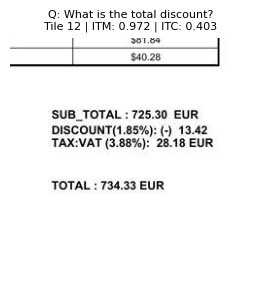


🟡 Pregunta: "What is the total discount?"
  Mejor tile #12 con mayor ITC
  Box: (345, 591, 595, 841)
  ITC: 0.4028
  ITM: 0.9721


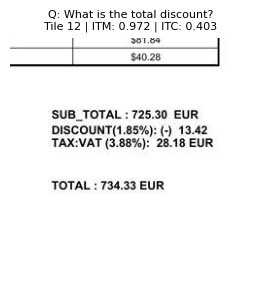


🟡 Pregunta: "the address?"
  Mejor tile #1 con mayor ITM
  Box: (0, 0, 250, 250)
  ITC: 0.3301
  ITM: 0.7431


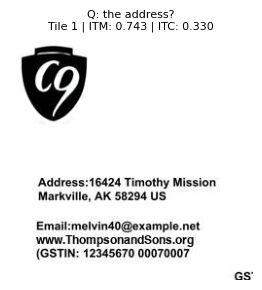


🟡 Pregunta: "the address?"
  Mejor tile #1 con mayor ITC
  Box: (0, 0, 250, 250)
  ITC: 0.3301
  ITM: 0.7431


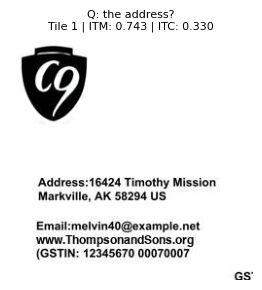


📷 Imagen: Template1_Instance175.jpg

🟡 Pregunta: "What is the total discount?"
  Mejor tile #12 con mayor ITM
  Box: (345, 591, 595, 841)
  ITC: 0.3952
  ITM: 0.9694


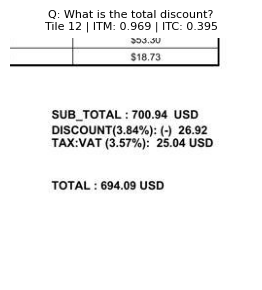


🟡 Pregunta: "What is the total discount?"
  Mejor tile #12 con mayor ITC
  Box: (345, 591, 595, 841)
  ITC: 0.3952
  ITM: 0.9694


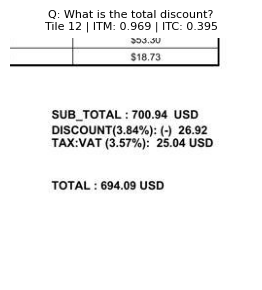


🟡 Pregunta: "the address?"
  Mejor tile #1 con mayor ITM
  Box: (0, 0, 250, 250)
  ITC: 0.3301
  ITM: 0.7431


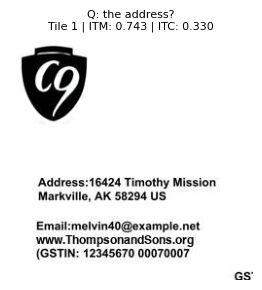


🟡 Pregunta: "the address?"
  Mejor tile #1 con mayor ITC
  Box: (0, 0, 250, 250)
  ITC: 0.3301
  ITM: 0.7431


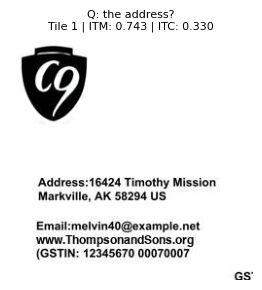


📷 Imagen: Template2_Instance38.jpg

🟡 Pregunta: "What is the total discount?"
  Mejor tile #9 con mayor ITM
  Box: (345, 394, 595, 644)
  ITC: 0.3579
  ITM: 0.5829


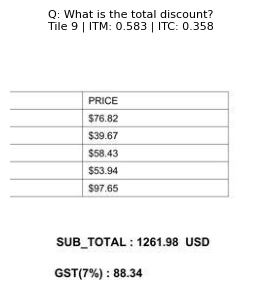


🟡 Pregunta: "What is the total discount?"
  Mejor tile #12 con mayor ITC
  Box: (345, 591, 595, 841)
  ITC: 0.3638
  ITM: 0.4310


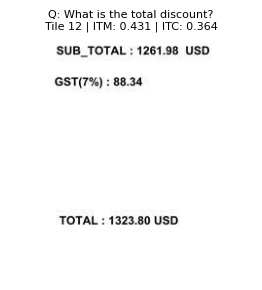


🟡 Pregunta: "the address?"
  Mejor tile #1 con mayor ITM
  Box: (0, 0, 250, 250)
  ITC: 0.3422
  ITM: 0.7032


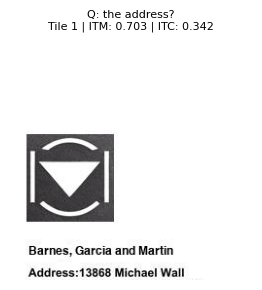


🟡 Pregunta: "the address?"
  Mejor tile #1 con mayor ITC
  Box: (0, 0, 250, 250)
  ITC: 0.3422
  ITM: 0.7032


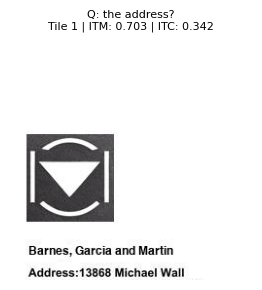


📷 Imagen: Template4_Instance9.jpg

🟡 Pregunta: "What is the total discount?"
  Mejor tile #9 con mayor ITM
  Box: (345, 394, 595, 644)
  ITC: 0.4116
  ITM: 0.9784


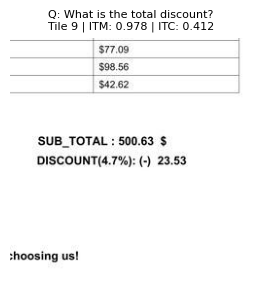


🟡 Pregunta: "What is the total discount?"
  Mejor tile #9 con mayor ITC
  Box: (345, 394, 595, 644)
  ITC: 0.4116
  ITM: 0.9784


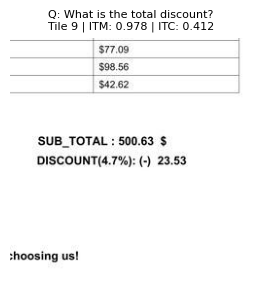


🟡 Pregunta: "the address?"
  Mejor tile #1 con mayor ITM
  Box: (0, 0, 250, 250)
  ITC: 0.2470
  ITM: 0.1799


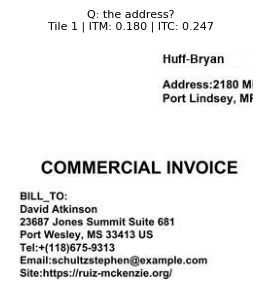


🟡 Pregunta: "the address?"
  Mejor tile #4 con mayor ITC
  Box: (0, 197, 250, 447)
  ITC: 0.2586
  ITM: 0.0912


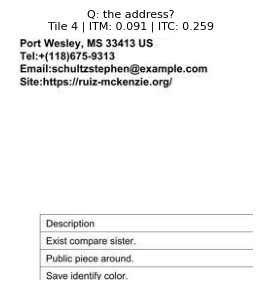


📷 Imagen: Template5_Instance138.jpg

🟡 Pregunta: "What is the total discount?"
  Mejor tile #7 con mayor ITM
  Box: (0, 394, 250, 644)
  ITC: 0.2835
  ITM: 0.7433


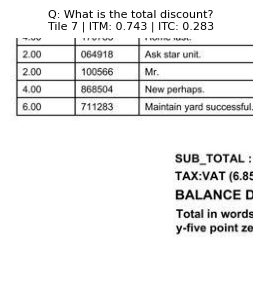


🟡 Pregunta: "What is the total discount?"
  Mejor tile #8 con mayor ITC
  Box: (172, 394, 422, 644)
  ITC: 0.3204
  ITM: 0.6257


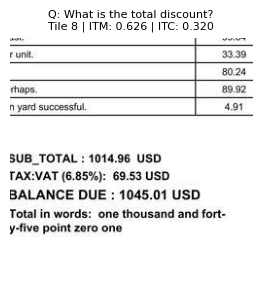


🟡 Pregunta: "the address?"
  Mejor tile #1 con mayor ITM
  Box: (0, 0, 250, 250)
  ITC: 0.3169
  ITM: 0.4084


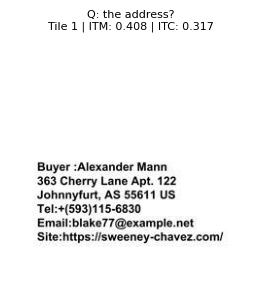


🟡 Pregunta: "the address?"
  Mejor tile #1 con mayor ITC
  Box: (0, 0, 250, 250)
  ITC: 0.3169
  ITM: 0.4084


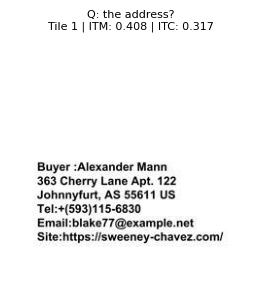


📷 Imagen: Template7_Instance158.jpg

🟡 Pregunta: "What is the total discount?"
  Mejor tile #8 con mayor ITM
  Box: (172, 394, 422, 644)
  ITC: 0.3724
  ITM: 0.8501


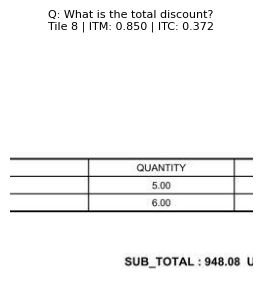


🟡 Pregunta: "What is the total discount?"
  Mejor tile #11 con mayor ITC
  Box: (172, 591, 422, 841)
  ITC: 0.3871
  ITM: 0.7383


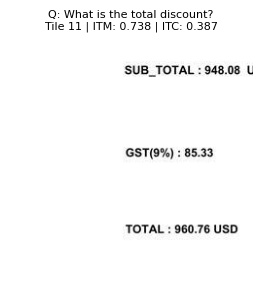


🟡 Pregunta: "the address?"
  Mejor tile #4 con mayor ITM
  Box: (0, 197, 250, 447)
  ITC: 0.2802
  ITM: 0.3613


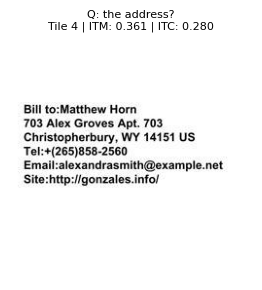


🟡 Pregunta: "the address?"
  Mejor tile #4 con mayor ITC
  Box: (0, 197, 250, 447)
  ITC: 0.2802
  ITM: 0.3613


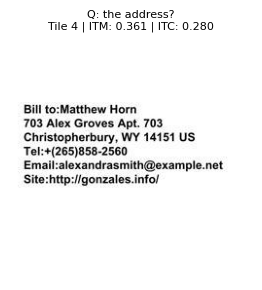


📷 Imagen: Template10_Instance97.jpg

🟡 Pregunta: "What is the total discount?"
  Mejor tile #8 con mayor ITM
  Box: (172, 394, 422, 644)
  ITC: 0.3965
  ITM: 0.9926


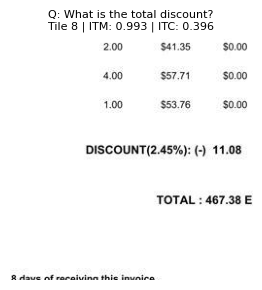


🟡 Pregunta: "What is the total discount?"
  Mejor tile #8 con mayor ITC
  Box: (172, 394, 422, 644)
  ITC: 0.3965
  ITM: 0.9926


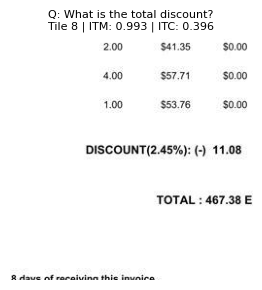


🟡 Pregunta: "the address?"
  Mejor tile #2 con mayor ITM
  Box: (172, 0, 422, 250)
  ITC: 0.3360
  ITM: 0.8724


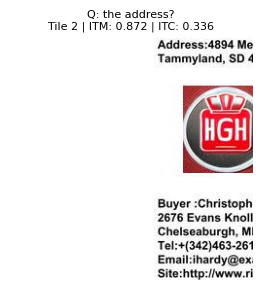


🟡 Pregunta: "the address?"
  Mejor tile #2 con mayor ITC
  Box: (172, 0, 422, 250)
  ITC: 0.3360
  ITM: 0.8724


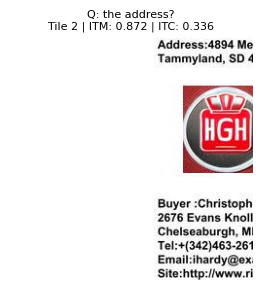


📷 Imagen: docmodificado.png

🟡 Pregunta: "What is the total discount?"
  Mejor tile #19 con mayor ITM
  Box: (340, 819, 590, 1069)
  ITC: 0.3626
  ITM: 0.9918


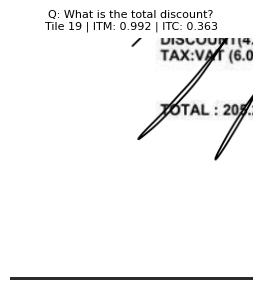


🟡 Pregunta: "What is the total discount?"
  Mejor tile #15 con mayor ITC
  Box: (340, 614, 590, 864)
  ITC: 0.3871
  ITM: 0.9832


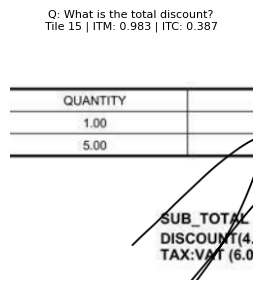


🟡 Pregunta: "the address?"
  Mejor tile #1 con mayor ITM
  Box: (0, 0, 250, 250)
  ITC: 0.3437
  ITM: 0.9756


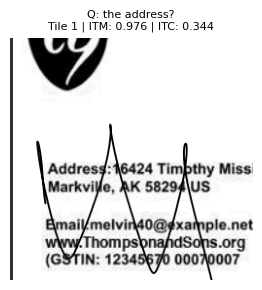


🟡 Pregunta: "the address?"
  Mejor tile #1 con mayor ITC
  Box: (0, 0, 250, 250)
  ITC: 0.3437
  ITM: 0.9756


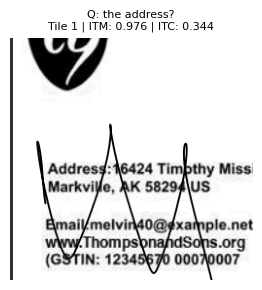


📷 Imagen: documentoemojis.png

🟡 Pregunta: "What is the total discount?"
  Mejor tile #20 con mayor ITM
  Box: (511, 819, 761, 1069)
  ITC: 0.2833
  ITM: 0.9954


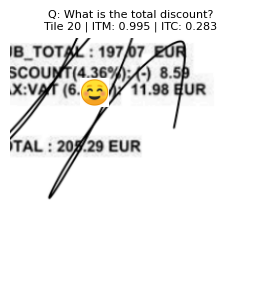


🟡 Pregunta: "What is the total discount?"
  Mejor tile #15 con mayor ITC
  Box: (340, 614, 590, 864)
  ITC: 0.3944
  ITM: 0.9921


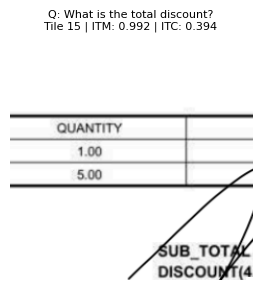


🟡 Pregunta: "the address?"
  Mejor tile #1 con mayor ITM
  Box: (0, 0, 250, 250)
  ITC: 0.2977
  ITM: 0.5844


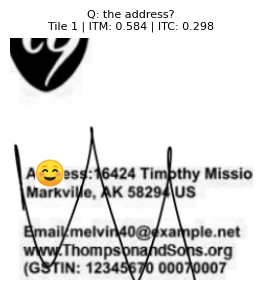


🟡 Pregunta: "the address?"
  Mejor tile #1 con mayor ITC
  Box: (0, 0, 250, 250)
  ITC: 0.2977
  ITM: 0.5844


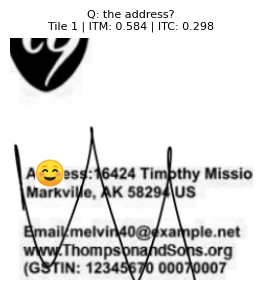


🟡 Pregunta: "an emoji"
  Mejor tile #9 con mayor ITM
  Box: (0, 409, 250, 659)
  ITC: 0.4232
  ITM: 0.9014


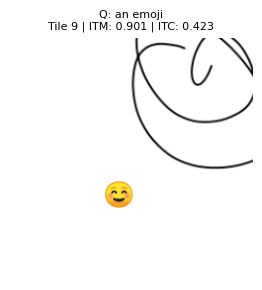


🟡 Pregunta: "an emoji"
  Mejor tile #9 con mayor ITC
  Box: (0, 409, 250, 659)
  ITC: 0.4232
  ITM: 0.9014


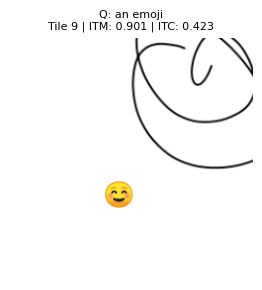

In [2]:
import os
import math
import torch
from PIL import Image
from typing import List, Tuple, Dict
from models.blip_itm import blip_itm
from torchvision import transforms
import matplotlib.pyplot as plt

#proceso la imagen descargada
def load_local_image(image_size, device, image_path):
    raw_image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                             (0.26862954, 0.26130258, 0.27577711))])
    image = transform(raw_image).unsqueeze(0).to(device)
    return raw_image, image

#calculo el solape entre cada celda para un numero de pixeles dado
def calcular_solape_exacto(dimension_total, tam_tile):
    n_tiles = math.ceil((dimension_total - tam_tile) / (tam_tile - 1e-6)) + 1
    stride = (dimension_total - tam_tile) / (n_tiles - 1) if n_tiles > 1 else 0
    solape = tam_tile - stride
    return solape, n_tiles

#printeo las celdas
def make_grid_boxes(img: Image.Image, tam_tile=250) -> List[Tuple[int, int, int, int]]:
    w, h = img.size
    solape_w, n_cols = calcular_solape_exacto(w, tam_tile)
    solape_h, n_rows = calcular_solape_exacto(h, tam_tile)
    boxes = []

    for i in range(n_rows):
        for j in range(n_cols):
            x0 = int(j * (tam_tile - solape_w))
            y0 = int(i * (tam_tile - solape_h))
            x1 = x0 + tam_tile
            y1 = y0 + tam_tile

            if x1 > w:
                x1 = w
                x0 = w - tam_tile
            if y1 > h:
                y1 = h
                y0 = h - tam_tile

            boxes.append((x0, y0, x1, y1))

    return boxes

def show_tile_with_scores(tile: Image.Image, idx: int, question: str, box: Tuple[int, int, int, int], itm: float, itc: float):
    plt.figure(figsize=(3, 3))
    plt.imshow(tile)
    plt.axis("off")
    plt.title(f"Q: {question}\nTile {idx} | ITM: {itm:.3f} | ITC: {itc:.3f}", fontsize=8)
    plt.tight_layout()
    plt.show()
#calculo scores para cada pregunta de cada imagen
def evaluar_imagenes_y_preguntas(
    imagenes_y_preguntas: Dict[str, List[str]],
    model,
    image_size=384,
    tam_tile=250,
    device='cuda'
):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                             (0.26862954, 0.26130258, 0.27577711))])

    for image_path, preguntas in imagenes_y_preguntas.items():
        print(f"\n📷 Imagen: {os.path.basename(image_path)}")
        raw_image, _ = load_local_image(image_size, device, image_path)
        boxes = make_grid_boxes(raw_image, tam_tile=tam_tile)

        for pregunta in preguntas:
            best_itc,best_itc2 = -1,-1
            best_itm,best_itm2 = -1,-1
            best_tile,best_tile2 = None, None
            best_box, best_box2 = None, None
            best_idx,best_idx2 = -1,-1
            for idx, box in enumerate(boxes):
                tile = raw_image.crop(box)
                tile_tensor = transform(tile).unsqueeze(0).to(device)

                itm_output = model(tile_tensor, pregunta, match_head='itm')
                itm_score = torch.nn.functional.softmax(itm_output, dim=1)[:, 1].item()

                itc_score = model(tile_tensor, pregunta, match_head='itc').item()

                if itm_score > best_itm:
                    best_itc = itc_score
                    best_itm = itm_score
                    best_tile = tile
                    best_box = box
                    best_idx = idx

                if itc_score > best_itc2:
                    best_itc2 = itc_score
                    best_itm2 = itm_score
                    best_tile2 = tile
                    best_box2 = box
                    best_idx2 = idx

            print(f"\n🟡 Pregunta: \"{pregunta}\"")
            print(f"  Mejor tile #{best_idx + 1} con mayor ITM")
            print(f"  Box: {best_box}")
            print(f"  ITC: {best_itc:.4f}")
            print(f"  ITM: {best_itm:.4f}")
            show_tile_with_scores(best_tile, best_idx + 1, pregunta, best_box, best_itm, best_itc)

            print(f"\n🟡 Pregunta: \"{pregunta}\"")
            print(f"  Mejor tile #{best_idx2 + 1} con mayor ITC")
            print(f"  Box: {best_box2}")
            print(f"  ITC: {best_itc2:.4f}")
            print(f"  ITM: {best_itm2:.4f}")
            show_tile_with_scores(best_tile2, best_idx2 + 1, pregunta, best_box2, best_itm2, best_itc2)

# === CONFIGURACIÓN ===

# Diccionario con imagen: lista de preguntas
imagenes_y_preguntas = {
    "/home/anovalbos/halldetect/segclip/blip1/docs_variados/Template1_Instance0.jpg": [
        "What is the total discount?",
        "the address?"
        
    ],
    "/home/anovalbos/halldetect/segclip/blip1/docs_variados/Template1_Instance175.jpg": [
        "What is the total discount?",
        "the address?"
    ],
    "/home/anovalbos/halldetect/segclip/blip1/docs_variados/Template2_Instance38.jpg": [
        "What is the total discount?",
        "the address?"
    ],
    "/home/anovalbos/halldetect/segclip/blip1/docs_variados/Template4_Instance9.jpg": [
        "What is the total discount?",
        "the address?"
    ],
    "/home/anovalbos/halldetect/segclip/blip1/docs_variados/Template5_Instance138.jpg": [
        "What is the total discount?",
        "the address?"
    ],
     "/home/anovalbos/halldetect/segclip/blip1/docs_variados/Template7_Instance158.jpg": [
        "What is the total discount?",
        "the address?"
    ],
      "/home/anovalbos/halldetect/segclip/blip1/docs_variados/Template10_Instance97.jpg": [
        "What is the total discount?",
        "the address?"
    ],
    "/home/anovalbos/halldetect/segclip/blip1/docs_variados/docmodificado.png": [
        "What is the total discount?",
        "the address?"
    ],
    "/home/anovalbos/halldetect/segclip/blip1/docs_variados/documentoemojis.png": [
        "What is the total discount?",
        "the address?",
        "an emoji"
    ],

}

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = blip_itm(pretrained=model_url, image_size=384, vit='base').to(device)
model.eval()

# Ejecutar
evaluar_imagenes_y_preguntas(imagenes_y_preguntas, model, image_size=384, tam_tile=250, device=device)
